In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install pyspark
import pyspark

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.ml.feature import Imputer
from pyspark.sql.functions import median
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import DecisionTreeClassifier

Defaulting to user installation because normal site-packages is not writeable


In [3]:
spark = SparkSession.builder.appName('Debit').getOrCreate()

In [4]:
spark

In [5]:
## Loading file

In [6]:
df = spark.read.csv("train.csv", header=True, inferSchema=True)

In [7]:
df.show(5)

+---+------------+--------+-----------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+---+
|age|         job| marital|        education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|  y|
+---+------------+--------+-----------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+---+
| 49| blue-collar| married|         basic.9y|unknown|     no|  no| cellular|  nov|        wed|     227|       4|  999|       0|nonexistent| no|
| 37|entrepreneur| married|university.degree|     no|     no|  no|telephone|  nov|        wed|     202|       2|  999|       1|    failure| no|
| 78|     retired| married|         basic.4y|     no|     no|  no| cellular|  jul|        mon|    1148|       1|  999|       0|nonexistent|yes|
| 36|      admin.| married|university.degree|     no|    yes|  no|telephone|  may|        mon|     120|       2|  999|       0|nonexiste

In [8]:
df.toPandas().head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,no


In [9]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



In [10]:
df.count()

32950

In [11]:
df.describe().toPandas()

,summary,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,count,32950,32950,32950,32950,32950,32950,32950,32950,32950,32950,32950,32950,32950,32950,32950,32950
1,mean,40.01411229135053,None,None,None,None,None,None,None,None,None,258.12746585735965,2.5606069802731413,962.0524127465858,0.17471927162367223,None,None
2,stddev,10.403636392152169,None,None,None,None,None,None,None,None,None,258.975917416652,2.752325782438183,187.95109589755918,0.4990245470883119,None,None
3,min,17,admin.,divorced,basic.4y,no,no,no,cellular,apr,fri,0,1,0,0,failure,no
4,max,98,unknown,unknown,unknown,yes,yes,yes,telephone,sep,wed,4918,56,999,7,success,yes


In [12]:
## Checking for null values

In [13]:
null_counts = df.agg(*[F.sum(F.col(c).isNull().cast("int").alias(c)) for c in df.columns])

In [14]:
null_counts.show()

+--------------------------------------+--------------------------------------+----------------------------------------------+--------------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------+----------------------------------------------+------------------------------------------+------------------------------------------------------+------------------------------------------------+------------------------------------------------+------------------------------------------+------------------------------------------------+------------------------------------------------+----------------------------------+
|sum(CAST((age IS NULL) AS INT) AS age)|sum(CAST((job IS NULL) AS INT) AS job)|sum(CAST((marital IS NULL) AS INT) AS marital)|sum(CAST((education IS NULL) AS INT) AS education)|sum(CAST((default IS NULL) AS INT) AS default)|sum(CAST((housing IS NULL) AS INT) AS housin

In [15]:
## It has not any null value

In [16]:
## Checking for dublicates values

In [17]:
df = df.dropDuplicates()

In [18]:
df.count()   #see line 11

32942

In [19]:
## Finding all non numeric features

In [20]:
df.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('month', 'string'),
 ('day_of_week', 'string'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('y', 'string')]

In [21]:
##Filter columns based on the condition (not type int)
cat_variables = [col_name for col_name, col_type in df.dtypes if col_type != 'int']
cat_variables

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome',
 'y']

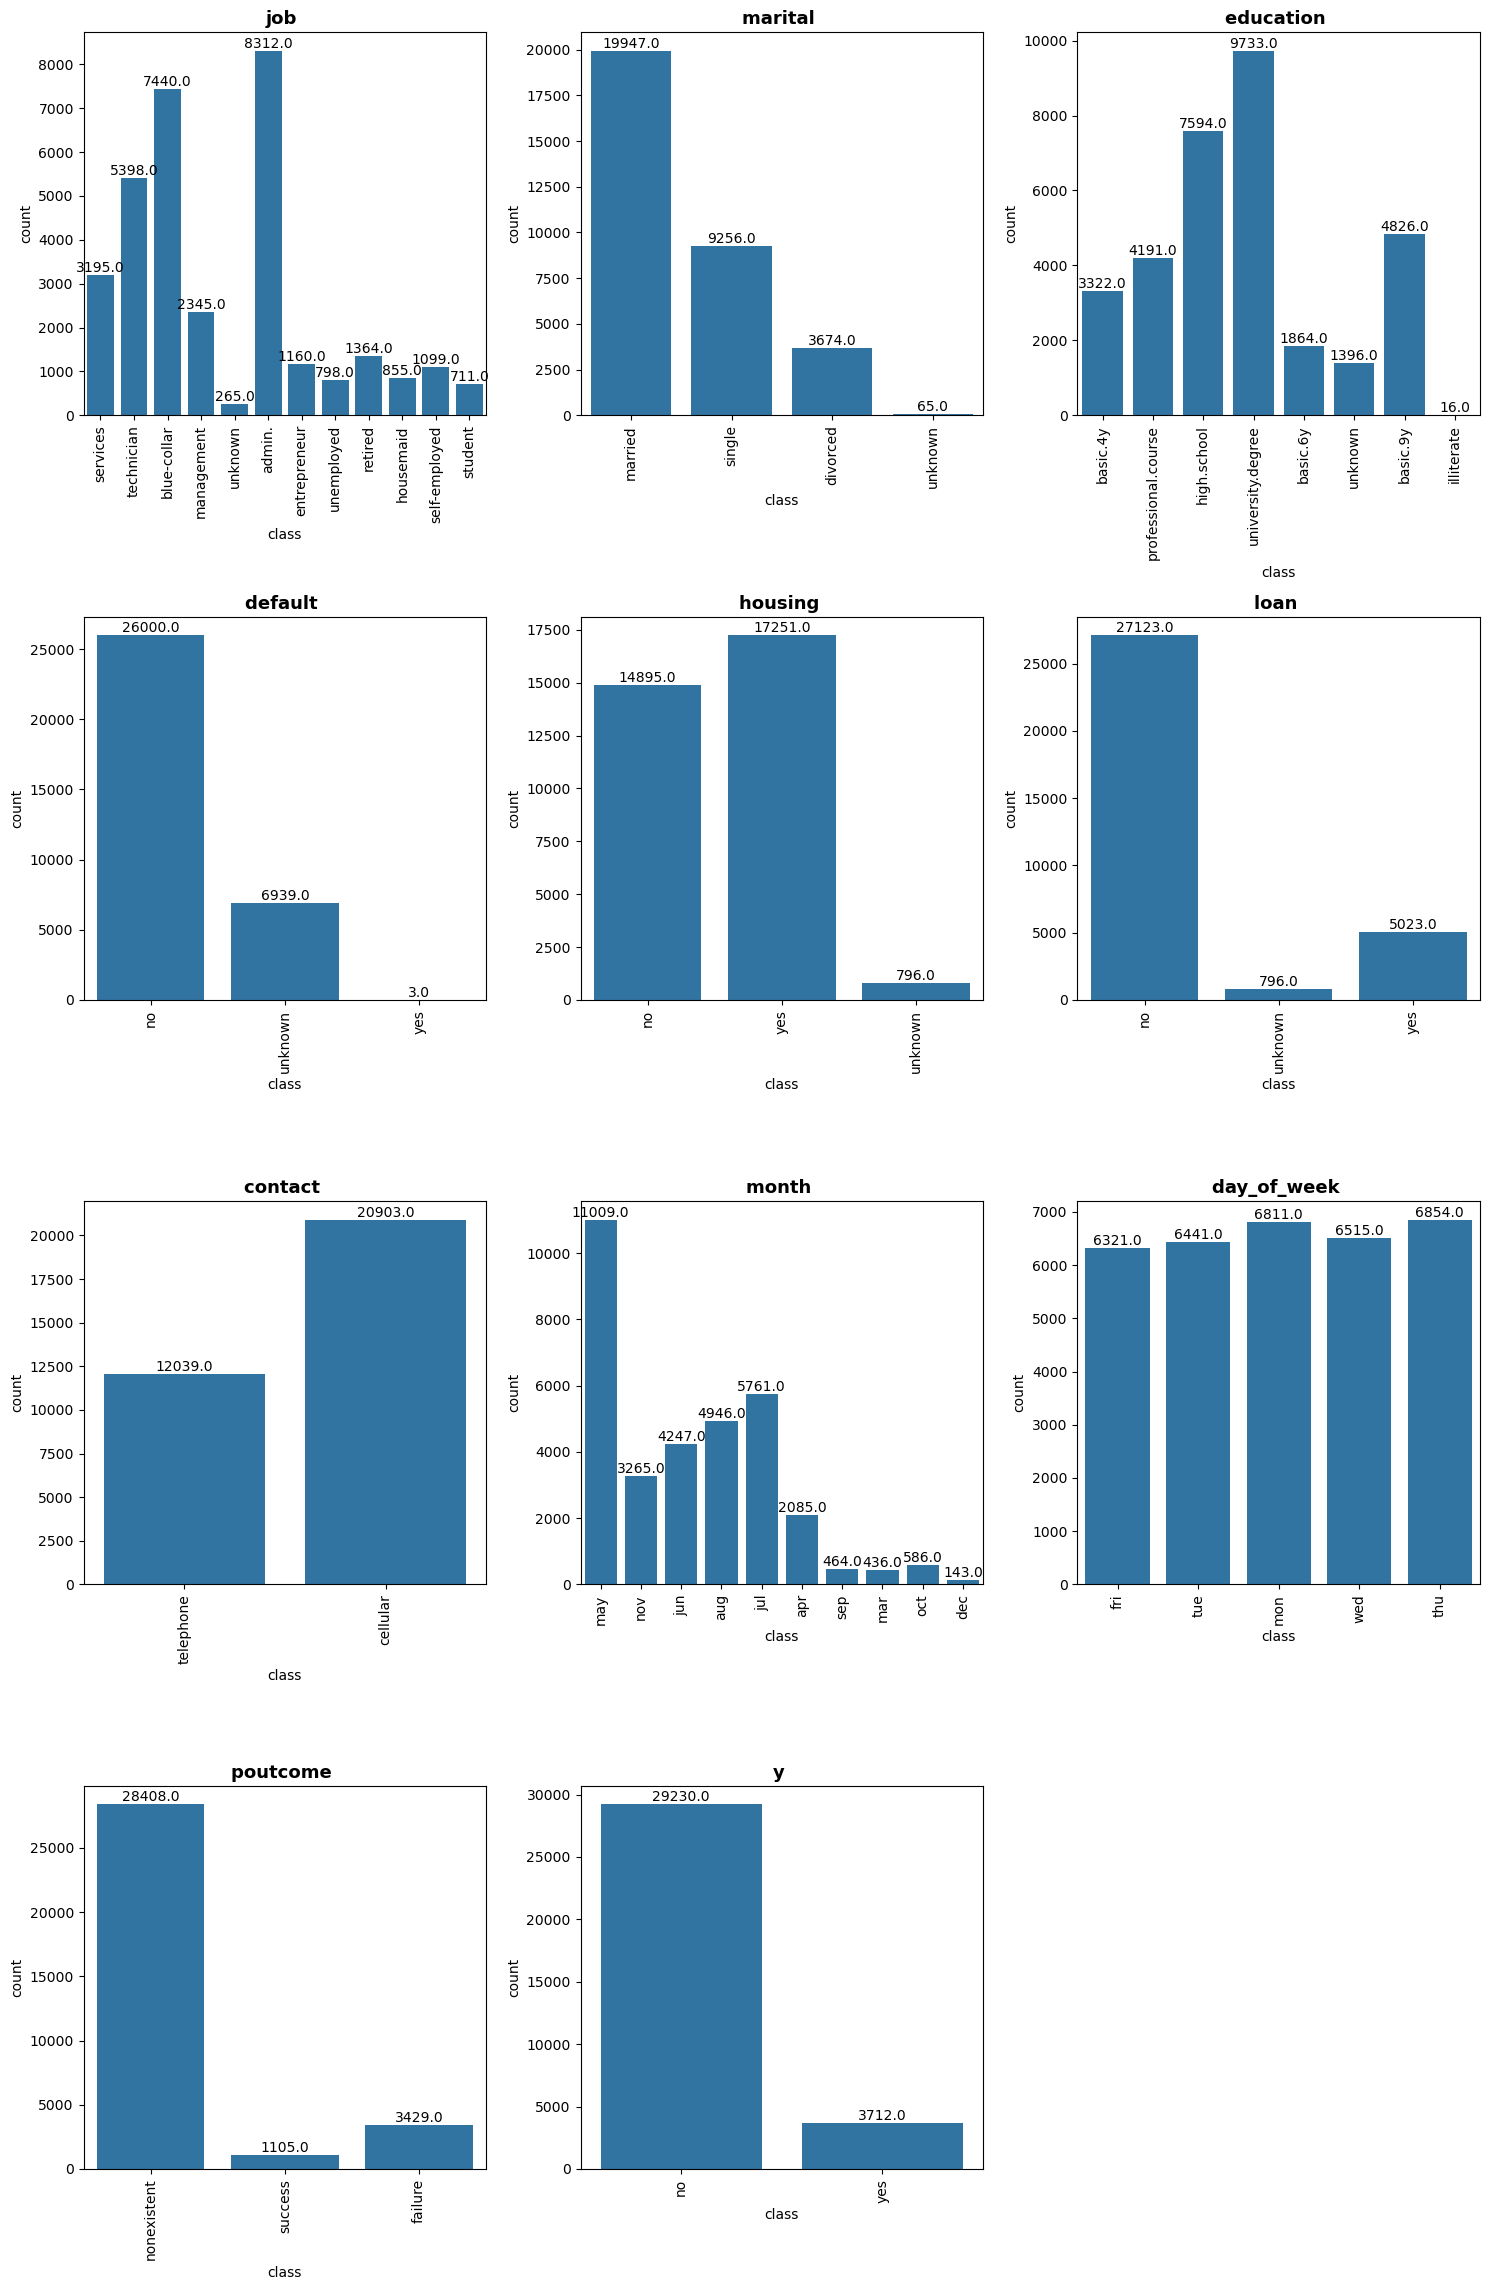

In [22]:
# Create subplots for count plots

plt.figure(figsize=(15, 23))

for i, col in enumerate(cat_variables, 1):
    plt.subplot(4, 3, i)
    ax = sns.countplot(data=df.toPandas(), x=col)
    for bar in ax.patches:
        height = bar.get_height() 
        ax.annotate(f'{height}', (bar.get_x() + bar.get_width() / 2, height),
                    ha='center', va='bottom')
    plt.title(f"{col} ",fontsize=13, fontweight="black")
    plt.xticks(rotation=90)
    plt.ylabel("count")
    plt.xlabel("class")

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


In [23]:
## What we have found

## We have found that the top profession that our customers belong is administration, the second highest job that customers do is blue-collar after this the technicians jobs come.
## The marital feature shows most of the customers are married.
## Majority customers are university degree holders and very only few are iliterate.
## Majority of the customers do not have a credit in default.
## Most of the customers have applied for a housing loan but very few have applied for personal loans.
## Cell-phones seem to be the most favoured method of reaching out to customers.
## In the month of May, many customers have been contacted.
## Previous marketing campaign outcome success rate is very low.

In [24]:
num_variables = [col_name for col_name, col_type in df.dtypes if col_type == 'int']

In [25]:
num_variables

['age', 'duration', 'campaign', 'pdays', 'previous']

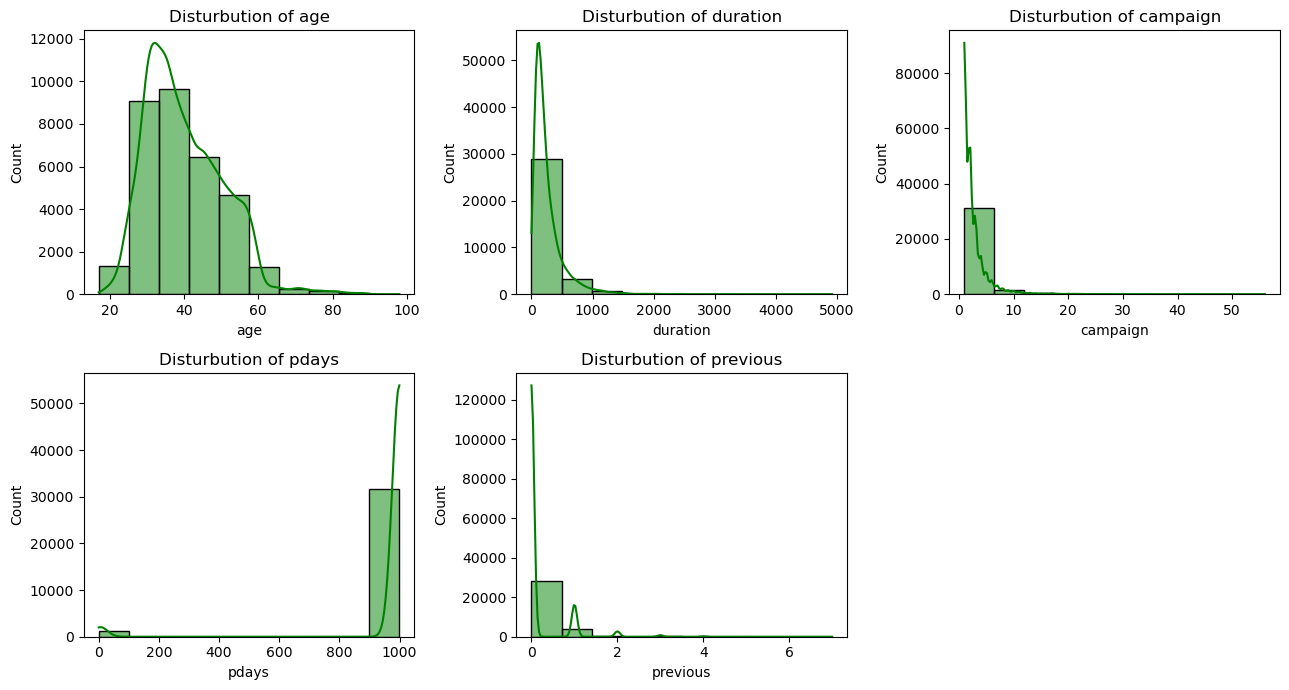

In [26]:
plt.figure(figsize=(13,7))
for i, cols in enumerate(num_variables):
  plt.subplot(2, 3, i+1)
  sns.histplot(df.toPandas(), x=cols, kde=True, bins=10, color="green")
  plt.title(f"Disturbution of {cols}")
plt.tight_layout()
plt.show()

In [27]:
## From the distplot of Age feature, we can observe that most of custmoers are above 20 and below 40.
## All the other plots are heavily skewed.

In [28]:
## Studying the relationships between features

In [29]:
# Changing the name from y to Deposit so it would make more sense

In [30]:
df = df.withColumnRenamed("y", "Deposit")
cat_variables.remove("y")

In [31]:
cat_variables

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

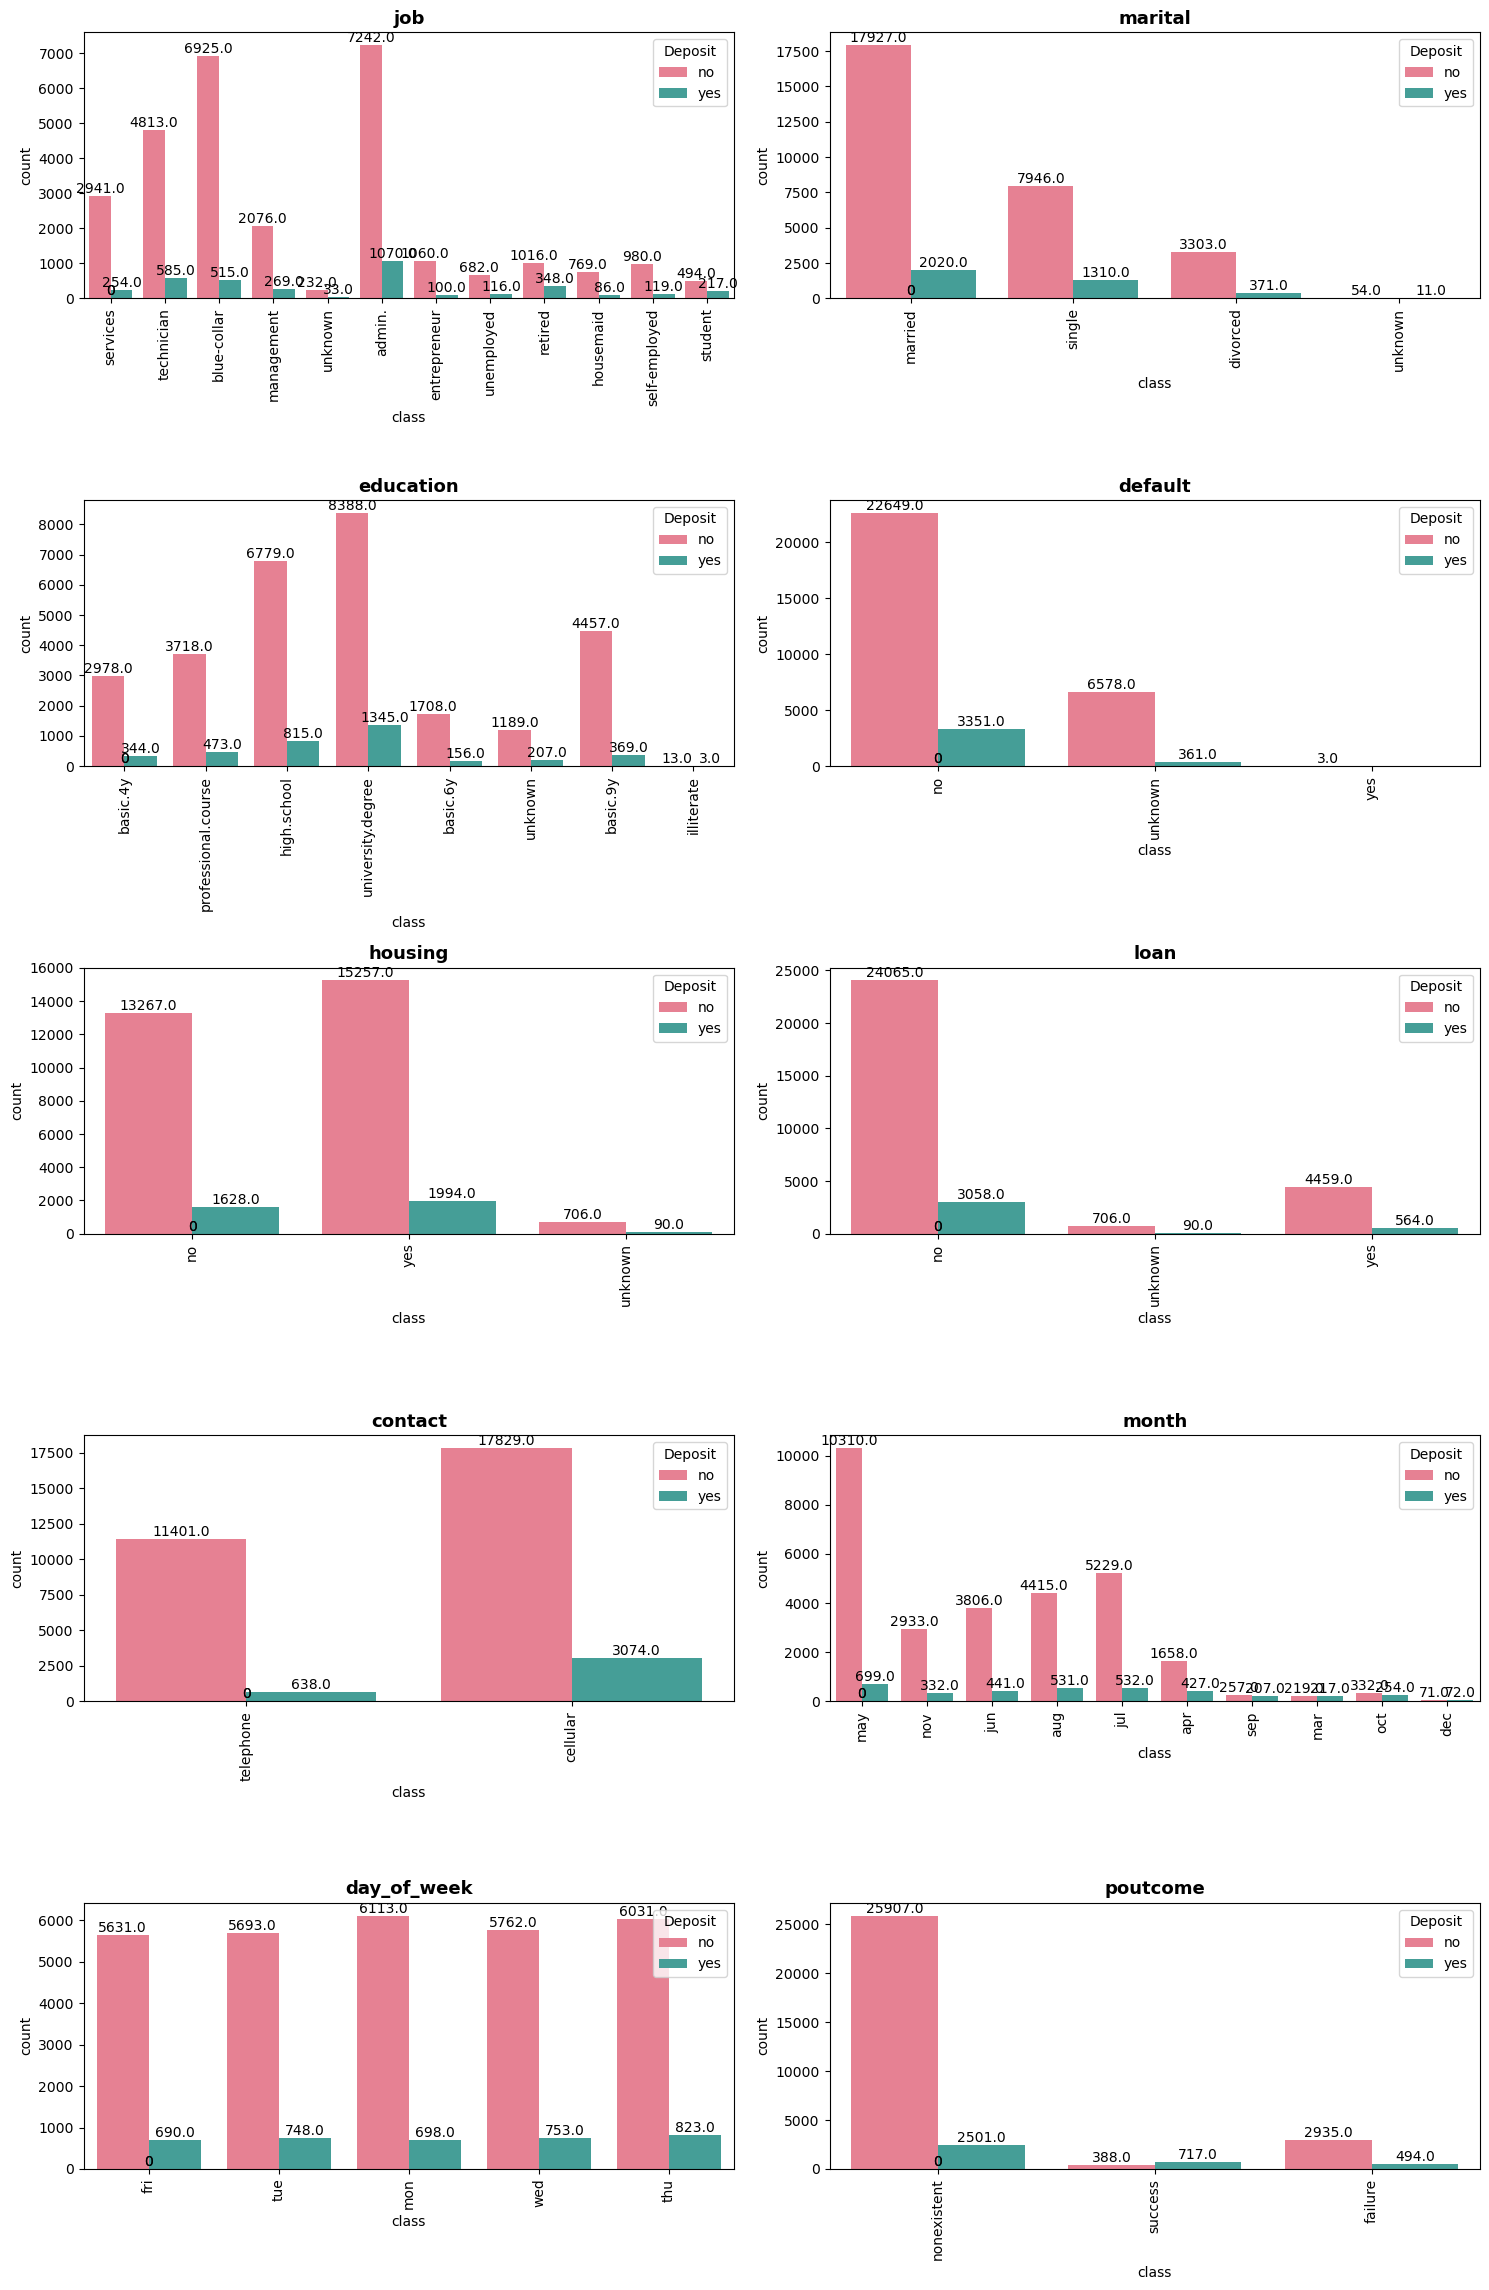

In [32]:

plt.figure(figsize=(15, 23))


for i, col in enumerate(cat_variables):
    plt.subplot(5, 2, i + 1)
    ax = sns.countplot(data=df.toPandas(), x=col, hue="Deposit", palette="husl")
    
    for bar in ax.patches:
        height = bar.get_height() 
        ax.annotate(f'{height}', (bar.get_x() + bar.get_width() / 2, height),
                    ha='center', va='bottom')

    plt.title(f"{col}", fontsize=13, fontweight="black")
    plt.xticks(rotation=90)
    plt.ylabel("count")
    plt.xlabel("class")

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


In [33]:
# Observations

## Amongst those customers who have subscirbed to the term deposit, are having administrative jobs.
## Marital status is that they are married.
## They hold a university degree
## They do not hold a credit in default.
## Housing loan doesn't seem a priority to check for since an equal number of customers who have and have not subscribed to it seem to have subscribed to the term deposit.
## Cell-phones should be the preferred mode of contact for contacting customers.

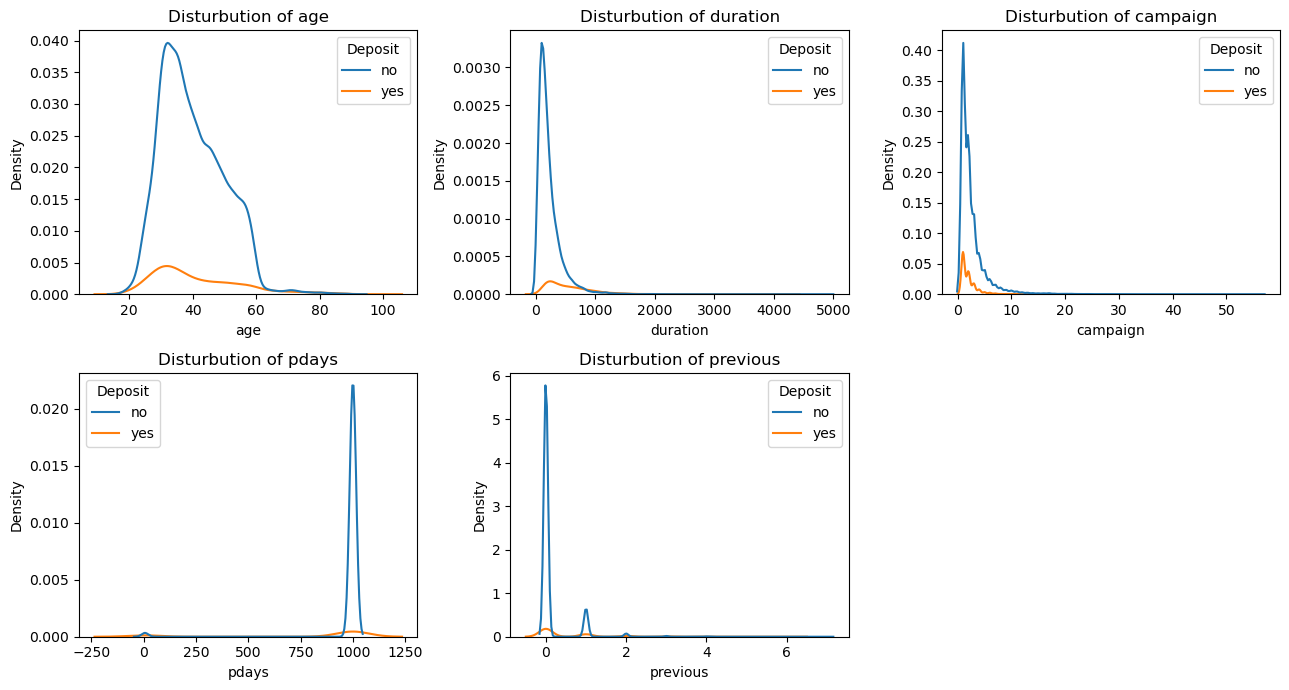

In [34]:
plt.figure(figsize=(13,7))
for i, cols in enumerate(num_variables):
  plt.subplot(2, 3, i+1)
  sns.kdeplot(df.toPandas(), x=cols, hue="Deposit", color="green")
  plt.title(f"Disturbution of {cols}")
plt.tight_layout()
plt.show()

In [35]:
## i didnt figure out any relationship because these features are very skewed

In [36]:
df.columns


['age',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'Deposit']

In [37]:
# StringIndexer Initialization
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="Deposit", outputCol="Deposit_Indexed")
indexerModel = indexer.fit(df)

# Transform the DataFrame using the fitted StringIndexer model
df = indexerModel.transform(df)
df.toPandas().head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,Deposit,Deposit_Indexed
0,58,services,married,basic.4y,no,no,no,telephone,may,fri,226,1,999,0,nonexistent,no,0.0
1,39,technician,single,professional.course,no,yes,no,cellular,nov,tue,58,1,999,0,nonexistent,no,0.0
2,32,blue-collar,single,high.school,no,no,no,cellular,jun,mon,247,1,2,2,success,yes,1.0
3,47,management,married,university.degree,no,yes,no,cellular,aug,tue,133,8,999,0,nonexistent,no,0.0
4,34,technician,married,professional.course,no,yes,no,telephone,jul,tue,389,7,999,0,nonexistent,no,0.0


In [38]:
df = df.drop("Deposit")

In [39]:
df.toPandas().head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,Deposit_Indexed
0,58,services,married,basic.4y,no,no,no,telephone,may,fri,226,1,999,0,nonexistent,0.0
1,39,technician,single,professional.course,no,yes,no,cellular,nov,tue,58,1,999,0,nonexistent,0.0
2,32,blue-collar,single,high.school,no,no,no,cellular,jun,mon,247,1,2,2,success,1.0
3,47,management,married,university.degree,no,yes,no,cellular,aug,tue,133,8,999,0,nonexistent,0.0
4,34,technician,married,professional.course,no,yes,no,telephone,jul,tue,389,7,999,0,nonexistent,0.0


In [40]:
# Finding th correlation

In [41]:
num_variables

['age', 'duration', 'campaign', 'pdays', 'previous']

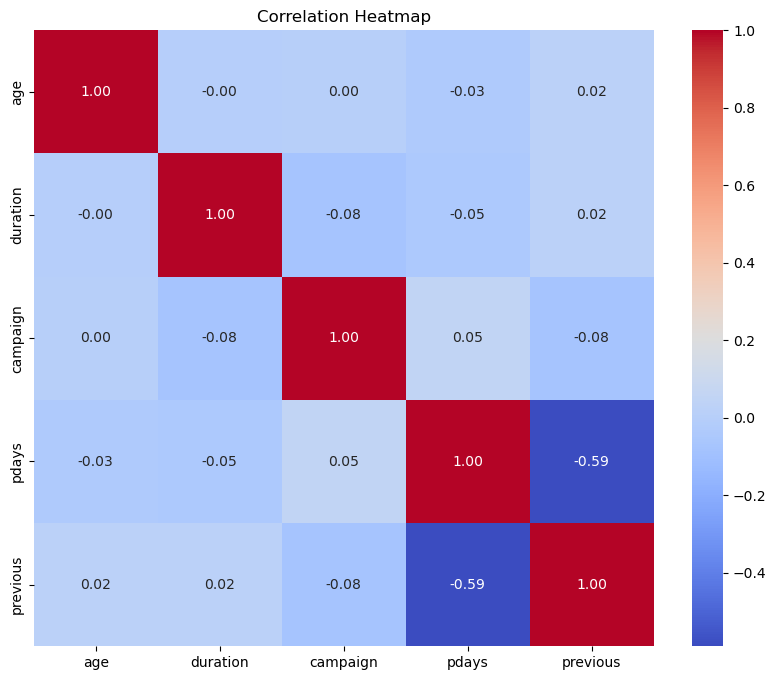

In [42]:
# Convert PySpark DataFrame to Pandas DataFrame
df_pandas = df.select(num_variables).toPandas()

# Compute correlation matrix
corr = df_pandas.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [43]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- Deposit_Indexed: double (nullable = false)



In [44]:
cat_variables

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [45]:
df1 = df.drop("Deposit_Indexed")

In [46]:
df1.toPandas().head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome
0,58,services,married,basic.4y,no,no,no,telephone,may,fri,226,1,999,0,nonexistent
1,39,technician,single,professional.course,no,yes,no,cellular,nov,tue,58,1,999,0,nonexistent
2,32,blue-collar,single,high.school,no,no,no,cellular,jun,mon,247,1,2,2,success
3,47,management,married,university.degree,no,yes,no,cellular,aug,tue,133,8,999,0,nonexistent
4,34,technician,married,professional.course,no,yes,no,telephone,jul,tue,389,7,999,0,nonexistent


In [47]:
from pyspark.ml.feature import StringIndexer

# Create a new DataFrame to store the indexed columns
indexed_df = df1

# Loop through each categorical column and encode it
for col in cat_variables:
    # Create a StringIndexer instance
    indexer = StringIndexer(inputCol=col, outputCol=col + "_indexed")
    
    # Fit the StringIndexer model and transform the DataFrame
    indexed_col = indexer.fit(indexed_df).transform(indexed_df)
    
    # Update the DataFrame with the new indexed column
    indexed_df = indexed_col

indexed_df.toPandas().head()



,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,job_indexed,marital_indexed,education_indexed,default_indexed,housing_indexed,loan_indexed,contact_indexed,month_indexed,day_of_week_indexed,poutcome_indexed
0,58,services,married,basic.4y,no,no,no,telephone,may,fri,...,3.0,0.0,4.0,0.0,1.0,0.0,1.0,0.0,4.0,0.0
1,39,technician,single,professional.course,no,yes,no,cellular,nov,tue,...,2.0,1.0,3.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0
2,32,blue-collar,single,high.school,no,no,no,cellular,jun,mon,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,3.0,1.0,2.0
3,47,management,married,university.degree,no,yes,no,cellular,aug,tue,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0
4,34,technician,married,professional.course,no,yes,no,telephone,jul,tue,...,2.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,3.0,0.0


In [48]:
dfu = indexed_df.drop(*cat_variables)

In [49]:
dfu.toPandas().head()

,age,duration,campaign,pdays,previous,job_indexed,marital_indexed,education_indexed,default_indexed,housing_indexed,loan_indexed,contact_indexed,month_indexed,day_of_week_indexed,poutcome_indexed
0,58,226,1,999,0,3.0,0.0,4.0,0.0,1.0,0.0,1.0,0.0,4.0,0.0
1,39,58,1,999,0,2.0,1.0,3.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0
2,32,247,1,2,2,1.0,1.0,1.0,0.0,1.0,0.0,0.0,3.0,1.0,2.0
3,47,133,8,999,0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0
4,34,389,7,999,0,2.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,3.0,0.0


In [50]:
# Dealing with the imbalanced dataset using SMOTE Technique

In [51]:
y = df.select("Deposit_indexed")
y.show()

+---------------+
|Deposit_indexed|
+---------------+
|            0.0|
|            0.0|
|            1.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            1.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            1.0|
|            0.0|
|            1.0|
|            1.0|
+---------------+
only showing top 20 rows



In [52]:
y_pandas = y.toPandas()

In [53]:
x = dfu

In [54]:
x_pandas = x.toPandas()

In [55]:
!pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable


In [56]:
from imblearn.over_sampling import SMOTE

In [57]:
x.count()

32942

In [58]:
y.count()

32942

In [59]:
smote = SMOTE(sampling_strategy = 'minority')
x_sm, y_sm = smote.fit_resample(x_pandas,y_pandas)

In [60]:
y_sm

,Deposit_indexed
0,0.0
1,0.0
2,1.0
3,0.0
4,0.0
...,...
58455,1.0
58456,1.0
58457,1.0
58458,1.0


In [67]:
y_sm.columns

Index(['Deposit_indexed'], dtype='object')

In [68]:
x_sm.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'job_indexed',
       'marital_indexed', 'education_indexed', 'default_indexed',
       'housing_indexed', 'loan_indexed', 'contact_indexed', 'month_indexed',
       'day_of_week_indexed', 'poutcome_indexed'],
      dtype='object')

In [61]:
# They are Pandas dataframes so we want to convert those to pyspark dataframes

In [311]:
y_spark = spark.createDataFrame(y_sm)
x_spark = spark.createDataFrame(x_sm)

In [ ]:
# scailing the data

In [317]:
features_columns = [x for x in x_sm.columns]

In [318]:
features_columns

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'job_indexed',
 'marital_indexed',
 'education_indexed',
 'default_indexed',
 'housing_indexed',
 'loan_indexed',
 'contact_indexed',
 'month_indexed',
 'day_of_week_indexed',
 'poutcome_indexed']

In [327]:
assembler = VectorAssembler(inputCols=features_columns, outputCol="features")

In [333]:
out = assembler.transform(x)

In [364]:
out.show()

+---+--------+--------+-----+--------+-----------+---------------+-----------------+---------------+---------------+------------+---------------+-------------+-------------------+----------------+--------------------+
|age|duration|campaign|pdays|previous|job_indexed|marital_indexed|education_indexed|default_indexed|housing_indexed|loan_indexed|contact_indexed|month_indexed|day_of_week_indexed|poutcome_indexed|            features|
+---+--------+--------+-----+--------+-----------+---------------+-----------------+---------------+---------------+------------+---------------+-------------+-------------------+----------------+--------------------+
| 58|     226|       1|  999|       0|        3.0|            0.0|              4.0|            0.0|            1.0|         0.0|            1.0|          0.0|                4.0|             0.0|[58.0,226.0,1.0,9...|
| 39|      58|       1|  999|       0|        2.0|            1.0|              3.0|            0.0|            0.0|         0.0

In [365]:
# Scailing the data

In [367]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)

In [370]:
x = scaler.fit(out).transform(out)

In [374]:
x.select("scaled_features").show()

+--------------------+
|     scaled_features|
+--------------------+
|[5.57529587469016...|
|[3.74890584677441...|
|[3.07602531017388...|
|(15,[0,1,2,3,5,12...|
|[3.26827689205974...|
|(15,[0,1,2,3,5,7,...|
|[3.84503163771735...|
|[4.99854112903255...|
|(15,[0,1,2,3,6,7,...|
|[4.32566059243202...|
|(15,[0,1,2,3,7,9,...|
|(15,[0,1,2,3,6,7,...|
|[5.09466691997549...|
|[3.65278005583148...|
|[5.09466691997549...|
|[4.90241533808962...|
|(15,[0,1,2,3,5,9,...|
|[5.28691850186136...|
|(15,[0,1,2,3,5,7,...|
|[7.49781169354883...|
+--------------------+
only showing top 20 rows



In [ ]:
# Step 4: Split data into training and test sets
(training_data, test_data) = df.randomSplit([0.8, 0.2])

# Step 5: Train the model
dt =  DecisionTreeClassifier(featuresCol="features", labelCol="label")
dt_model = lr.fit(training_data)


